<div class="alert alert-block alert-danger">
    <b> Unraveling the cytoskeletal architecture of cancer cells: a novel computational approach to predict cell fate - CODE</b> 
    
 **5 - PROCESSING**
    
**Author**: Diogo Fróis Vieira
</div>

<div class="alert alert-block alert-info">
    
 **IMPORTS**
    
</div>

In [1]:
# Math, image processing and other useful libraries
from __future__ import print_function, unicode_literals, absolute_import, division
import os

import pandas as pd
import numpy as np
import cv2
from collections import OrderedDict
import copy
import math
import pickle
from matplotlib.ticker import MaxNLocator
from itertools import combinations

# Image processing
from skimage.measure import regionprops
from skimage.filters import meijering, sato, frangi, hessian, threshold_otsu
from skimage.morphology import extrema, skeletonize
from skimage.transform import probabilistic_hough_line
from skimage.draw import disk, circle_perimeter
from scipy.ndimage import gaussian_filter, grey_closing
from scipy.spatial import distance_matrix
from skimage import data, restoration, util
from roipoly import RoiPoly
from matplotlib_scalebar.scalebar import ScaleBar
from biosppy.signals import tools
from biosppy.stats import pearson_correlation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as pltc
import matplotlib.colors as colors
import seaborn as sns

# Widgets
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

# Feature Extraction (.py files by Teresa Parreira)
# from CytoSkeletonPropsMorph import CytoSkeletonPropsMorph
# from CytoSkeletonRegionPropsInt import RegionPropsInt
# from FreqAnalysis import FreqAnalysis
# from GLCM import GLCM

# Graph
import sknw
import networkx as nx
from scipy.signal import argrelextrema

# 
from skan import Skeleton, summarize,draw
from skan.csr import skeleton_to_csgraph, sholl_analysis,make_degree_image
import scipy as sp
import scipy.sparse
from matplotlib.patches import Circle

from framework.Functions import cv2toski,pylsdtoski,polar_to_cartesian, remove_not1D, quantitative_analysis,hist_bin,hist_lim,branch,graphAnalysis
from framework.importing import *
from framework.preprocessingCYTO import *
#from framework.PreProcessingNUCL import excludeborder, nuclei_preprocessing, df_nuclei_preprocessing, nuclei_segmentation
from framework.processing import *
from framework.visualization import *
from framework.analysis import plot_barplot
from framework.processing_LSF import *
from framework.processing_DCF import *
from framework.processing_CNF import *
#from fractal_dimension import fractal_dimension
#from fractal_analysis_fxns import boxcount,boxcount_grayscale,fractal_dimension,fractal_dimension_grayscale,fractal_dimension_grayscale_DBC

print('📚 All libraries successfully imported 📚')

📚 All libraries successfully imported 📚


<div class="alert alert-block alert-info">
    
 **DIRECTORIES**
    
</div>

In [2]:
# Define dataset folder.
folder      = os.path.dirname(os.getcwd()) + "\\Datasets\\Set 1-a-tubulin_Sofia"

# Import images from CYTO, NUCL and RGB folders.
options     = ["CYTO","NUCL","RGB"]

# Function to automatically retrieve image labels and indexes.
denominator = label_tubulin

# Dictionary with keys "CYTO", "NUCL", "RGB".
data = init_import(folder,options,denominator)

# Import ROIs
ROIs = pickle.load(open(folder + '//ROIs//ROIs_TEST.pkl', 'rb'))

# Import preprocessed products
data['NUCL_PRE'] = pd.read_pickle(folder + "\\NUCL_PRE\\NUCL_PRE_TEST.pkl") # pd.read_pickle(os.getcwd() + "\\NUCL_PRE_2D_StarDist.pkl") #
data['CYTO_PRE'] = pd.read_pickle(folder + "\\CYTO_PRE\\CYTO_PRE_TEST.pkl") 

TiffPage 0: IndexError: tuple index out of range


>>> [RGB] added.
>>> [CYTO] added.
>>> [NUCL] added.


<div class="alert alert-block alert-info">
    
 **SELECT CELL**
    
</div>

In [3]:
def dropdown_cell_eventhandler(change):
    global cell
    cell = dropdown_image.value
    lab = ROIs['Label'][dropdown_image.value]
    print('Cell ' + str(cell) + ' (' + str(lab) +') selected.')

dropdown_image = widgets.Dropdown(description =  'Select Cell:' , options = ['...'] + list(ROIs.index))
dropdown_image.observe(dropdown_cell_eventhandler, names='value')
display(dropdown_image)

Dropdown(description='Select Cell:', options=('...', 0, 1), value='...')

Cell 1 (WT) selected.


<div class="alert alert-block alert-info">
    
 **PROCESS CELL**
    
</div>

In [4]:
ResultsDF = processing_cell(rowROI           = ROIs.loc[cell],
                            data             = data,
                            LSFparams        = {'res_thr': 4})

ResultsDF

,Path,Name,Img Index,Label,Image Size,Resolution,Mask,Skeleton,Patch:Deconvoluted Cyto,Patch:Deconvoluted Nucl,Patch:Skeleton Max,Offset,Nucleus Contour,Nucleus Centroid,Lines
0,C:\Users\diogo\OneDrive - Universidade de Lisb...,MAX_9_6IF_CHO_L_w3z_decon_ch02_PS.tif,9,WT,"(1040, 1388)","(1, 1.6e-05, 1.6e-05)","([676, 676, 676, 676, 677, 677, 677, 677, 677,...","([688, 688, 688, 688, 689, 689, 690, 690, 690,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[676, 676, 676, 676, 677, 677, 677, 677, 677,...","[[677, 686], [676, 687], [675, 687], [674, 688...","(711.042, 677.249)","[((668.185, 687.963), (669.815, 692.037)), ((6..."


<div class="alert alert-block alert-info">
    
 **PROCESSING DATAFRAME**
    
</div>

In [32]:
ResultsDF = df_processing_cell(data   = data,
                               ROIsDF = ROIs,
                               params = {'res_thr': 4 })

>>> Progress: 0.0% 0
>>> Progress: 0.095% 1
>>> Progress: 0.191% 2
>>> Progress: 0.286% 3
symmetric branch  True [[132. 901.]
 [133. 902.]
 [132. 903.]]
symmetric branch  True [[229. 932.]
 [230. 933.]
 [230. 934.]
 [230. 935.]
 [229. 936.]]
>>> Progress: 0.381% 4


,Name,Img Index,Label,Mask,Patch:Skeleton,Patch:Deconvoluted Cyto,Patch:Deconvoluted Nucl,Patch:Skeleton Max,Offset,Nucleus Contour,Nucleus Centroid,Graph,Lines
0,MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif,38,No transfection,"[[False, False, False, False, False, False, Fa...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[2, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6,...","[[846, 136], [845, 137], [844, 137], [843, 137...","(179.149, 847.657)",<skan.csr.Skeleton object at 0x000001A188B62A40>,"[((831.057, 8.057), (834.943, 11.943)), ((838...."
1,MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif,38,No transfection,"[[False, False, False, False, False, False, Fa...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[565, 565, 565, 565, 565, 566, 566, 566, 566,...","[[1158, 607], [1157, 608], [1156, 608], [1155,...","(634.605, 1142.831)",<skan.csr.Skeleton object at 0x000001A188B60C10>,"[((1183.139, 573.819), (1185.861, 575.181)), (..."
2,MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif,38,No transfection,"[[False, False, False, False, False, False, Fa...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, ...","[[846, 136], [845, 137], [844, 137], [843, 137...","(179.149, 847.657)",<skan.csr.Skeleton object at 0x000001A188B60FD0>,"[((835.713, 14.957), (834.826, 17.913)), ((834..."
3,MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif,38,No transfection,"[[False, False, False, False, False, False, Fa...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.13825933250494407, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[27, 28, 28, 29, 29, 29, 30, 30, 30, 30, 31, ...","[[880, 120], [879, 121], [878, 121], [877, 122...","(160.291, 893.033)",<skan.csr.Skeleton object at 0x000001A188B61990>,"[((852.558, 32.635), (862.383, 43.522)), ((866..."
4,MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif,38,No transfection,"[[False, False, False, False, False, False, Fa...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0004217225449038664, 0.0, 0.0, 0.0, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[71, 72, 72, 73, 73, 73, 74, 74, 74, 74, 75, ...","[[937, 143], [937, 144], [936, 145], [935, 145...","(191.66, 941.322)",<skan.csr.Skeleton object at 0x000001A188B61FF0>,"[((894.753, 97.268), (898.838, 102.033)), ((90..."


<div class="alert alert-block alert-info">
    
 **PLOT PROCESSED CELLS**
    
</div>

exception occured
Done.


C:\Users\diogo\OneDrive - Universidade de Lisboa\Ambiente de Trabalho\CYSK_Workspace\CYSK\framework\visualization.py:201: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\diogo\OneDrive - Universidade de Lisboa\Ambiente de Trabalho\CYSK_Workspace\CYSK\framework\visualization.py:244: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


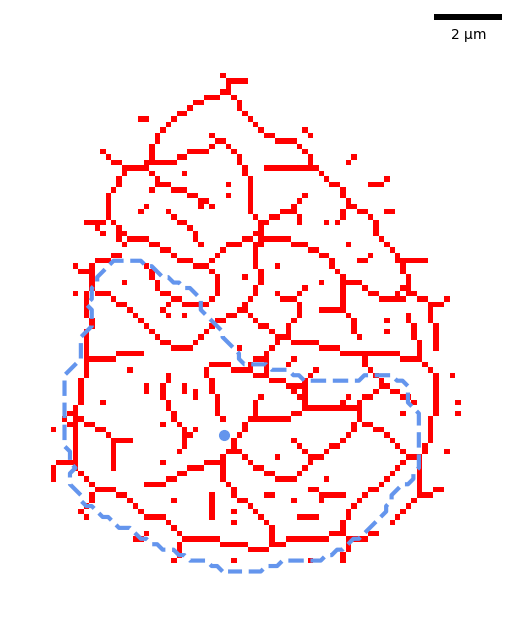

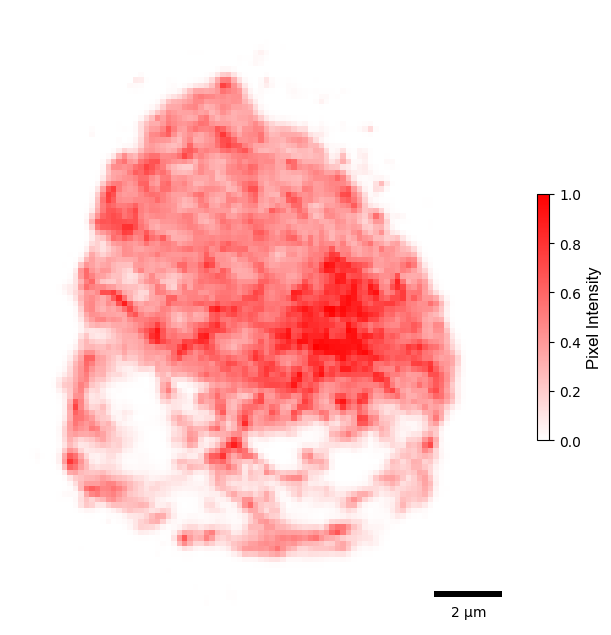

In [5]:
intensity_plotter(ResultsRow = ResultsDF.loc[0],
                  data       = data,
                  save       = False)    

exception occured
Done.


C:\Users\diogo\OneDrive - Universidade de Lisboa\Ambiente de Trabalho\CYSK_Workspace\CYSK\framework\visualization.py:324: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


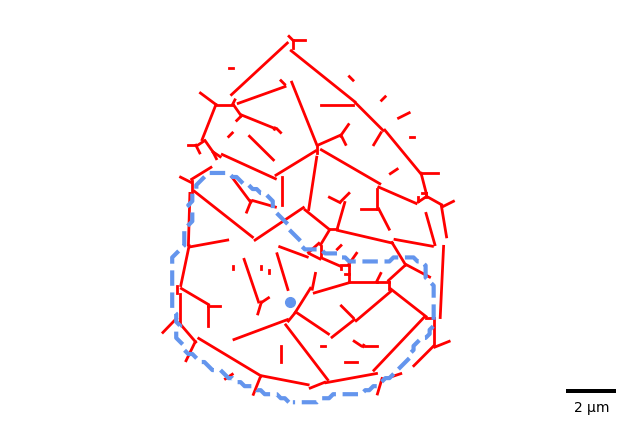

In [6]:
cmap     = pltc.rainbow
cm       = truncate_colormap(cmap, 0, 1, 300)

line_plotter(ResultsRow = ResultsDF.loc[0],
             data=data,
             feat=None,
             cmap=cm,
             normalize_bounds=1,
             colorbar_label=None,
             line_data_origin = 'Lines',
             overlay=True,
             save=False)

exception occured
Done.


C:\Users\diogo\OneDrive - Universidade de Lisboa\Ambiente de Trabalho\CYSK_Workspace\CYSK\framework\visualization.py:468: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


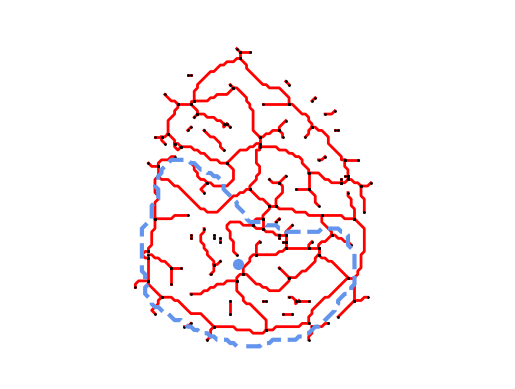

In [7]:
cmap     = pltc.rainbow
cm       = truncate_colormap(cmap, 0, 1, 300)

graph_plotter(ResultsRow       = ResultsDF.loc[0],
              data             = data,
              feat             = None,
              cmap             = cm,
              normalize_bounds = 'default',
              colorbar_label   = None,
              nodes            = True,
              main_branch      = False,
              overlay          = None,
              scalebar         = False,
              save             = False)

<div class="alert alert-block alert-info">
    
 **SAVE DATAFRAME FOR FEATURE EXTRACTION**
    
</div>

In [8]:
ResultsDF.to_pickle(folder + '//ResultsDF_TEST.pkl')   

---